# 期中報告

## 1. 引入套件

In [86]:
from datetime import datetime
from collections import Counter

import jieba
import jieba.analyse
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import math
import re
from nltk import ngrams
from nltk import FreqDist
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm
from collections import Counter, namedtuple

In [7]:
# 設定圖的字體
plt.rcParams['font.size'] = 14
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 2. 資料前處理

### 2.1 基本資料介紹
資料來源：
+ 工作流程平台蒐集PTT 機車版(biker)文章
+ 關鍵字:「電動機車、電動車、機車選購、充電、保養、優惠、服務、折扣」
+ 時間: 2020-01-01 ~ 2023-04-12
+ 資料筆數：共 1517 篇文章

In [8]:
#匯入資料
df = pd.read_csv('rawData/buyMotor_2017_2023.csv')
df

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,『若僅為新車問題或心得文章者則不需此範本』，請自行刪除所有內容。\r\n\r\n 欲比較車...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
1,2,https://www.ptt.cc/bbs/biker/M.1483383716.A.A3...,[討論]霧季到霧中行車該注意什麼?,2017-01-02 18:55:52,FECer,biker,這一兩天西部地區都有濃霧出現\r\n\r\n看到板上以前的文中有提到幾個在霧中行車該注意的\...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""blackhippo"",...",125.224.210.237,2018-04-29 07:05:28,ptt
2,3,https://www.ptt.cc/bbs/biker/M.1483416557.A.31...,[閒聊]白牌小車被逼車過的請進,2017-01-03 04:03:14,Haooconnor,biker,大家好，小弟我發這篇文不是來討拍，我想請問各位大大有沒有遇過惡劣的駕\r\n駛任意變換車道、...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Davil0130"", ...",223.141.199.140,2018-04-29 07:05:28,ptt
3,4,https://www.ptt.cc/bbs/biker/M.1483420431.A.5C...,[問題]請問這台二手SYMGT該下手嗎,2017-01-03 05:07:46,J0825N,biker,最近朋友有台車想賣\r\n\r\n是2014年出廠的SYM GT125\r\n\r\n車況滿...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""blackyy"", ""c...",101.12.103.223,2018-04-29 07:05:28,ptt
4,5,https://www.ptt.cc/bbs/biker/M.1483461332.A.DD...,Fw:[合作]《PTT聯合*書寶》年終公益募集活動,2017-01-03 16:29:31,Derek324kimo,biker,作者: tencc2871 (莫) 看板: BB_Book2017\r\n標題: [合作] ...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""samhou6"", ""c...",123.194.128.204,2018-04-29 07:05:28,ptt
...,...,...,...,...,...,...,...,...,...,...,...
2727,2728,https://www.ptt.cc/bbs/biker/M.1680008773.A.01...,[問題]輕檔通勤耐久後胎選擇,2023-03-28 21:06:10,OOQ,biker,小弟前年入手二手KAWASAKI Z300\r\n當時原車主剛換全新倍耐力ROSSO SPO...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""caca80207"", ...",36.235.201.215,2023-03-29 01:03:47,ptt
2728,2729,https://www.ptt.cc/bbs/biker/M.1680053137.A.3E...,[問題]二手fighter6跟全新迪爵,2023-03-29 09:25:34,wasley,biker,請問板上的大大\r\n最近想換車\r\n然後希望置物空間可以大一點\r\n目前的價格帶看到有...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""shingatter"",...",49.216.43.16,2023-03-30 01:03:54,ptt
2729,2730,https://www.ptt.cc/bbs/biker/M.1680099669.A.07...,[選購]jetsl/sr/勁戰六代,2023-03-29 22:21:07,relaxcloud,biker,《是否至車行看過實車》\r\n\r\nNo （算是吧？\r\n\r\n《欲比較之品牌及車種》...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""james725twtw...",36.226.25.23,2023-03-30 01:03:54,ptt
2730,2731,https://www.ptt.cc/bbs/biker/M.1680108698.A.B8...,[問題]二手該選雲豹200還是150?,2023-03-30 00:51:36,Raven29,biker,皆為2008年化油版(目前都還沒看到實車)\r\n\r\n《廠牌型號》 雲豹150 | 雲豹...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""a151091"", ""c...",116.241.162.145,2023-03-30 01:03:54,ptt


### 2.2 資料初步清理
清除內文為空值的文章<br>
透過觀察發現ptt的文章常用兩個換行符號作為句子的結尾，因此將兩個換行取代為句號，並清除不重要的字如換行、網址

In [9]:
clear_df = df.copy()

#去除有包含空值的筆數
clear_df.dropna(axis=0, how='any')

#用'。'取代'\n\n'，並移除'\n'
clear_df = clear_df.replace(r'\\n\\n', '。', regex=True).replace(r'\n', '', regex=True)

#移除內文中的網址
clear_df['artContent'] = clear_df['artContent'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,『若僅為新車問題或心得文章者則不需此範本』，請自行刪除所有內容。\r\r 欲比較車種時，請...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
1,2,https://www.ptt.cc/bbs/biker/M.1483383716.A.A3...,[討論]霧季到霧中行車該注意什麼?,2017-01-02 18:55:52,FECer,biker,這一兩天西部地區都有濃霧出現\r\r看到板上以前的文中有提到幾個在霧中行車該注意的\r\r放...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""blackhippo"",...",125.224.210.237,2018-04-29 07:05:28,ptt
2,3,https://www.ptt.cc/bbs/biker/M.1483416557.A.31...,[閒聊]白牌小車被逼車過的請進,2017-01-03 04:03:14,Haooconnor,biker,大家好，小弟我發這篇文不是來討拍，我想請問各位大大有沒有遇過惡劣的駕\r駛任意變換車道、急煞...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Davil0130"", ...",223.141.199.140,2018-04-29 07:05:28,ptt
3,4,https://www.ptt.cc/bbs/biker/M.1483420431.A.5C...,[問題]請問這台二手SYMGT該下手嗎,2017-01-03 05:07:46,J0825N,biker,最近朋友有台車想賣\r\r是2014年出廠的SYM GT125\r\r車況滿新的，平常都有在...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""blackyy"", ""c...",101.12.103.223,2018-04-29 07:05:28,ptt
4,5,https://www.ptt.cc/bbs/biker/M.1483461332.A.DD...,Fw:[合作]《PTT聯合*書寶》年終公益募集活動,2017-01-03 16:29:31,Derek324kimo,biker,作者: tencc2871 (莫) 看板: BB_Book2017\r標題: [合作] 《P...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""samhou6"", ""c...",123.194.128.204,2018-04-29 07:05:28,ptt
...,...,...,...,...,...,...,...,...,...,...,...
2727,2728,https://www.ptt.cc/bbs/biker/M.1680008773.A.01...,[問題]輕檔通勤耐久後胎選擇,2023-03-28 21:06:10,OOQ,biker,小弟前年入手二手KAWASAKI Z300\r當時原車主剛換全新倍耐力ROSSO SPORT...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""caca80207"", ...",36.235.201.215,2023-03-29 01:03:47,ptt
2728,2729,https://www.ptt.cc/bbs/biker/M.1680053137.A.3E...,[問題]二手fighter6跟全新迪爵,2023-03-29 09:25:34,wasley,biker,請問板上的大大\r最近想換車\r然後希望置物空間可以大一點\r目前的價格帶看到有\r二手的f...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""shingatter"",...",49.216.43.16,2023-03-30 01:03:54,ptt
2729,2730,https://www.ptt.cc/bbs/biker/M.1680099669.A.07...,[選購]jetsl/sr/勁戰六代,2023-03-29 22:21:07,relaxcloud,biker,《是否至車行看過實車》\r\rNo （算是吧？\r\r《欲比較之品牌及車種》\r\r(1)j...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""james725twtw...",36.226.25.23,2023-03-30 01:03:54,ptt
2730,2731,https://www.ptt.cc/bbs/biker/M.1680108698.A.B8...,[問題]二手該選雲豹200還是150?,2023-03-30 00:51:36,Raven29,biker,皆為2008年化油版(目前都還沒看到實車)\r\r《廠牌型號》 雲豹150 | 雲豹200\...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""a151091"", ""c...",116.241.162.145,2023-03-30 01:03:54,ptt


### 2.3 斷句
中文主要以標點符號進行斷句，並清除空的字串

In [10]:
clear_df['artContent'] = clear_df['artContent'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('artContent').reset_index(drop=True)

# 把長度小於1的content刪掉
sent_df = sent_df[sent_df["artContent"].str.len() > 1]

sent_df

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,『若僅為新車問題或心得文章者則不需此範本』,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
1,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,請自行刪除所有內容,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
2,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,\r\r 欲比較車種時,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
3,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,請在標題打上車種名稱,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
4,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"如：GSR/新勁戰/RS\r 請勿使用""請問新車""、""請推薦車""等過於模糊不方便搜尋的標題...","[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
...,...,...,...,...,...,...,...,...,...,...,...
50135,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,若lx fl改為相同形\r式,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt
50136,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,是否行車質感及運動性也與pmv車系相去不遠,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt
50137,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,\r\r3.3vie iget 差異\r請問這兩款除了新舊及動力上的差異,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt
50138,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,在耐久度跟運轉品質上是否有差,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt


### 2.4 斷詞
斷詞引擎設定：使用 Jieba 當作斷詞系統。
Jieba原先內建為簡體字字典，但我們可以使用繁體字典來做為替換，結果會比較好。另外可能還有一些專有名詞是沒有被包含在預設字典當中，我們也可以使用自定義字典的方式加入，或者使用參數的形式帶入。

In [11]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt
# 將user_dict改為以下字詞陳吉仲、好市多、好事多、產蛋率、吉仲
jieba.set_dictionary('dict/dict.txt')
jieba.load_userdict('dict/user_dict.txt')

Building prefix dict from c:\Users\collin\Desktop\socialMedia_project\dict\dict.txt ...
Loading model from cache C:\Users\collin\AppData\Local\Temp\jieba.u5ae51a7e740c9af1ab5a92f566d53c76.cache
Loading model cost 0.306 seconds.
Prefix dict has been built successfully.


斷詞前先將標點符號清除，並清除空字串

In [12]:
sent_df['artContent'] = sent_df['artContent'].str.replace(r'[^\w\s\d]+', '', regex=True).astype(str)
sent_df = sent_df[sent_df["artContent"].str.len() > 1]

sent_df

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,若僅為新車問題或心得文章者則不需此範本,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
1,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,請自行刪除所有內容,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
2,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,\r\r 欲比較車種時,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
3,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,請在標題打上車種名稱,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
4,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,如GSR新勁戰RS\r 請勿使用請問新車請推薦車等過於模糊不方便搜尋的標題\r\r 請自...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
...,...,...,...,...,...,...,...,...,...,...,...
50135,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,若lx fl改為相同形\r式,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt
50136,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,是否行車質感及運動性也與pmv車系相去不遠,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt
50137,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,\r\r33vie iget 差異\r請問這兩款除了新舊及動力上的差異,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt
50138,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,在耐久度跟運轉品質上是否有差,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt


使用jieba進行斷詞

In [13]:
word_df = sent_df.assign(word = sent_df['artContent'].apply(jieba.lcut)).explode('word').drop(['artContent'], axis=1)

word_df = word_df.loc[word_df['word'].str.len()>1]

word_df

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artComment,e_ip,insertedDate,dataSource,word
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,若僅
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,新車
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,問題
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,心得
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,文章
...,...,...,...,...,...,...,...,...,...,...,...
50138,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,品質
50138,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,是否
50138,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,有差
50139,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,感謝


### 2.5 移除停用字

In [14]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
# 新增目前、連結、標題、知道、報導、指出....等停用字
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 

移除dataframe中的停用字

In [15]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artComment,e_ip,insertedDate,dataSource,word
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,若僅
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,新車
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,問題
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,心得
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,文章
...,...,...,...,...,...,...,...,...,...,...,...
50138,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,耐久度
50138,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,運轉
50138,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,品質
50138,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,有差


### 2.6 計算詞頻

In [16]:
freq_df = pd.DataFrame({'freq':noStop_df.groupby(['word']).size().sort_values(ascending=False)}).reset_index(drop = False)

clist = ['word','freq']
freq_df = freq_df[clist]
freq_df

,word,freq
0,機車,2169
1,問題,1750
2,車行,1492
3,目前,1364
4,補助,1182
...,...,...
41259,五六千,1
41260,會浮,1
41261,會期,1
41262,五六次,1


### 2.7 視覺化結果

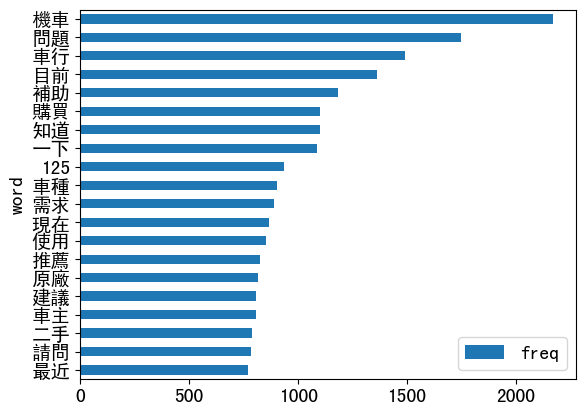

In [17]:
freq_df.iloc[:20].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

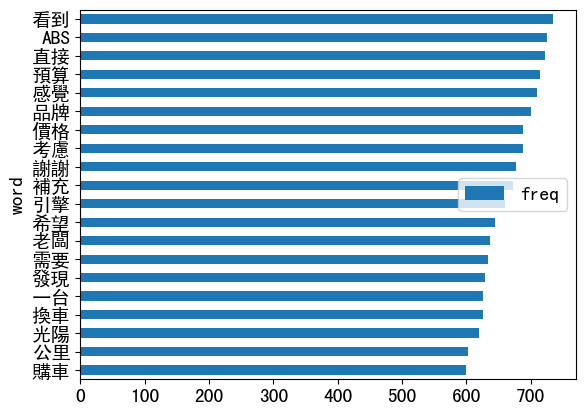

In [18]:
freq_df.iloc[20:40].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

### 2.8 更新停用字字典

In [19]:
# 參數形式手動加入停用字
stopwords_manual = ["謝謝", "一下", "問題", "感覺", "目前", "請問", "發現", "直接", "知道", "看到", "現在", "車子", "建議", "車主", "希望", "10", "一點", "機車", "最近", "老闆", "時間", "車行", "購買", "一台", "Yes", "小弟", "XD", "左右", "之後", "這台", "有沒有", "這種"]
stopwords.extend(stopwords_manual)

In [20]:
noStop_df_2 = noStop_df[~noStop_df['word'].isin(stopwords)]
noStop_df_2

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artComment,e_ip,insertedDate,dataSource,word
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,若僅
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,新車
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,心得
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,文章
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,者則
...,...,...,...,...,...,...,...,...,...,...,...
50138,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,耐久度
50138,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,運轉
50138,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,品質
50138,2732,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,[問題]vespa車系,2023-03-30 07:28:02,slowpace,biker,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""family2006"",...",27.53.48.156,2023-03-31 01:03:33,ptt,有差


#### 重新計算詞頻

In [16]:
freq_df_2 = pd.DataFrame({'freq':noStop_df_2.groupby(['word']).size().sort_values(ascending=False)}).reset_index(drop = False)

clist = ['word','freq']  
freq_df_2 = freq_df_2[clist]
freq_df_2

,word,freq
0,補助,1182
1,125,935
2,車種,904
3,需求,888
4,使用,853
...,...,...
41228,插拔,1
41229,插嘴,1
41230,插反,1
41231,插卡處,1


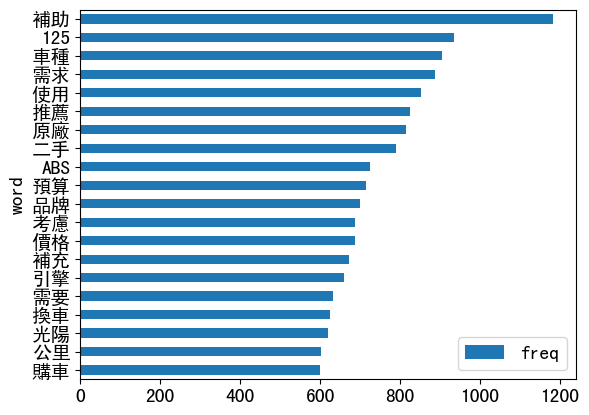

In [17]:
freq_df_2.iloc[:20].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

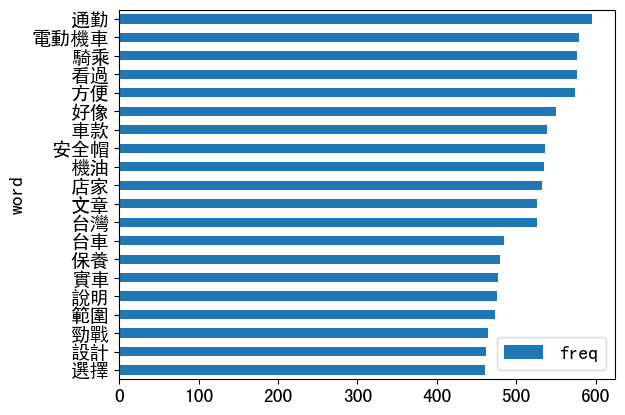

In [18]:
freq_df_2.iloc[20: 40].plot.barh(x='word', y='freq').invert_yaxis()
plt.show()

### 2.9 繪製文字雲

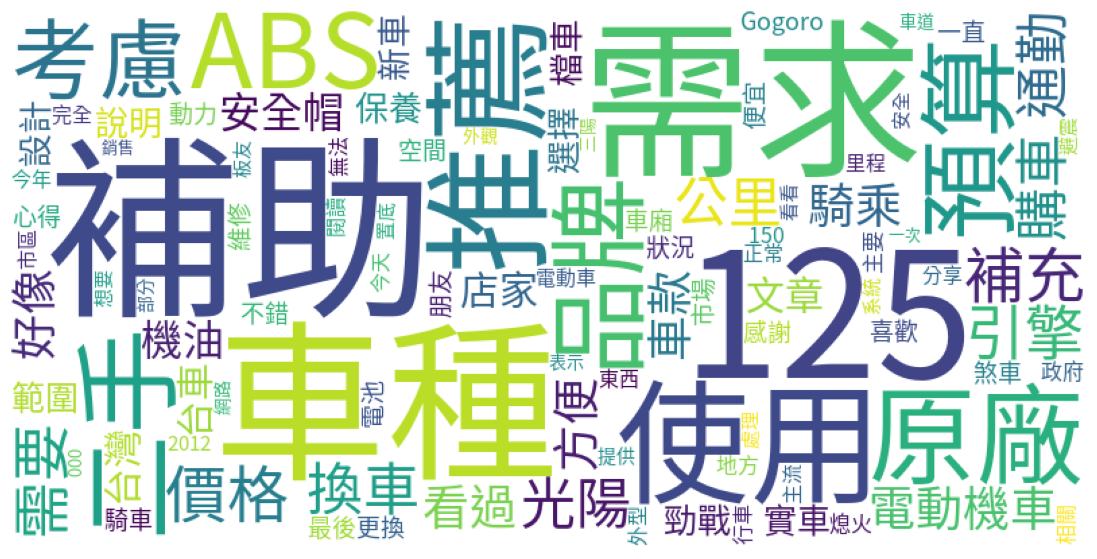

In [19]:
# 詞頻變成dict
freq_dict = freq_df_2.set_index('word', inplace=False).to_dict()
freq_dict = freq_dict['freq']

# 繪製文字雲
FontPath = 'rawData/SourceHanSansTW-Regular.otf' # 設定字型
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=FontPath, max_words=100)
wordcloud.generate_from_frequencies(freq_dict)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis('off')
# plt.show()

# 儲存並顯示文字雲
plt.savefig('pic/wordcloud.png', bbox_inches='tight')

## 3. lexicon-base 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 3.1 準備LIWC字典  

In [20]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [21]:
ptt_df = noStop_df_2.copy()
ptt_df["artDate"] = pd.to_datetime(ptt_df["artDate"])

In [22]:
ptt_df["artDate"].describe(datetime_is_numeric=True)

count                           292741
mean     2020-02-21 04:37:22.600376832
min                2017-01-02 14:38:41
25%                2018-09-18 14:57:18
50%                2020-03-11 22:02:58
75%                2021-06-26 22:56:37
max                2023-03-30 07:28:02
Name: artDate, dtype: object

In [23]:
ptt_df["artDate"] = ptt_df["artDate"].dt.date

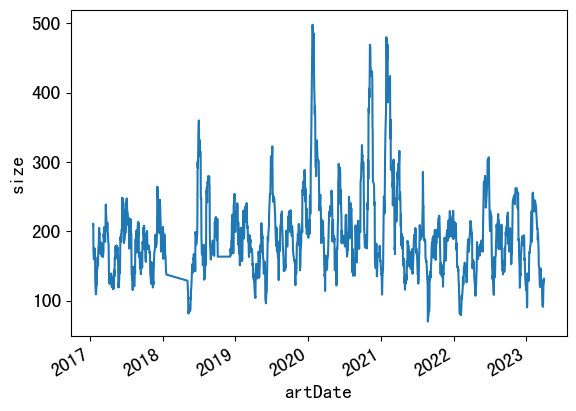

In [24]:
ptt_line_plot = ptt_df.groupby(["artDate"], as_index=False).size()

fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_line_plot["artDate"], ptt_line_plot["size"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel('size')
fig.autofmt_xdate()
plt.show()

### 3.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。。

In [25]:
ptt_liwc_df = pd.merge(ptt_df[["artDate", "artUrl", "word"]], liwc_dict, how="left")
ptt_liwc_df

,artDate,artUrl,word,sentiments
0,2017-01-02,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,若僅,NaN
1,2017-01-02,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,新車,NaN
2,2017-01-02,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,心得,NaN
3,2017-01-02,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,文章,NaN
4,2017-01-02,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,者則,NaN
...,...,...,...,...
308067,2023-03-30,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,運轉,NaN
308068,2023-03-30,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,品質,NaN
308069,2023-03-30,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,有差,NaN
308070,2023-03-30,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,感謝,affect


### 3.3 正負向情緒分數聲量折線圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

In [26]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"], dropna=False, as_index=False).size()
)
sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

,artDate,sentiments,size
0,2017-01-02,affect,8
1,2017-01-02,negative,2
2,2017-01-02,positive,5
3,2017-01-02,NaN,177
4,2017-01-03,affect,42
...,...,...,...
6539,2023-03-29,anx,2
6543,2023-03-29,NaN,107
6545,2023-03-30,positive,1
6544,2023-03-30,affect,2


In [27]:
sentiment_count["sentiments"] == "positive"

0       False
1       False
2        True
3       False
4       False
        ...  
6539    False
6543    False
6545     True
6544    False
6546    False
Name: sentiments, Length: 6547, dtype: bool

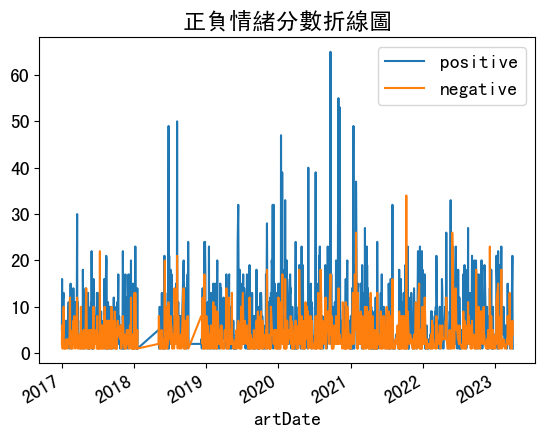

In [28]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒分數折線圖")  # 記得加上才能顯示中文
plt.show()

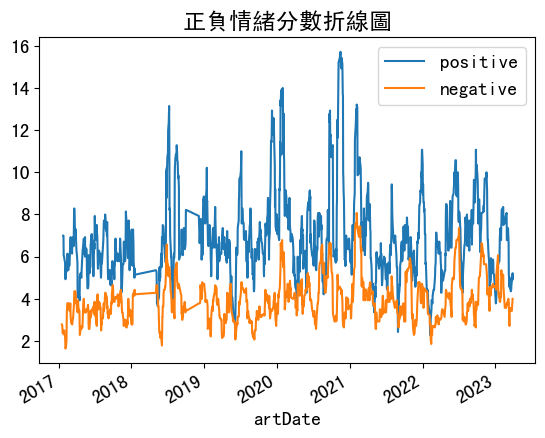

In [29]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天移動平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒分數折線圖")  # 記得加上才能顯示中文
plt.show()

### 3.4 正負向情緒分數比例折線圖

In [30]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

,artDate,sentiments,size,ratio
0,2017-01-02,affect,8,0.041667
1,2017-01-02,negative,2,0.010417
2,2017-01-02,positive,5,0.026042
3,2017-01-02,NaN,177,0.921875
4,2017-01-03,affect,42,0.065523
...,...,...,...,...
6539,2023-03-29,anx,2,0.015504
6543,2023-03-29,NaN,107,0.829457
6545,2023-03-30,positive,1,0.007519
6544,2023-03-30,affect,2,0.015038


In [31]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

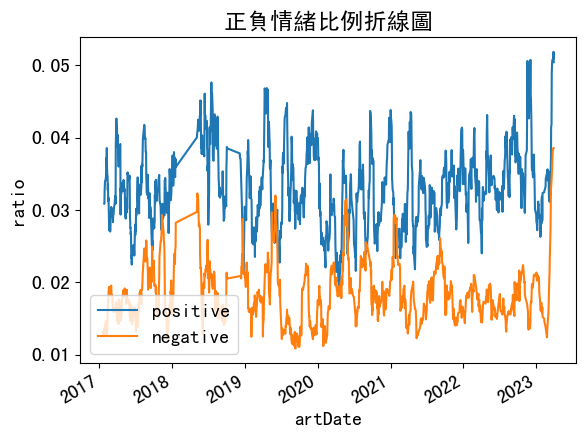

In [32]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖")

### 3.5 文字雲
針對不同日期畫出該天的文字雲，如果文字雲中的字詞大小越大，代表出現頻率越高

In [33]:
mask = sentiment_count['sentiments'] == 'positive'
sentiment_count.loc[mask,:].sort_values("size", ascending=False).head()

,artDate,sentiments,size,ratio
3937,2020-09-20,positive,65,0.056868
4094,2020-10-30,positive,55,0.034396
4126,2020-11-06,positive,53,0.043983
1626,2018-08-07,positive,50,0.040617
1463,2018-06-25,positive,49,0.045455


#### 2020-10-30 文字雲

In [34]:
date = "2020-10-30"
mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date))
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

C:\Users\collin\AppData\Local\Temp\ipykernel_17668\4125349688.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date))


[('BWS', 32),
 ('125', 23),
 ('車款', 18),
 ('設計', 17),
 ('全新', 12),
 ('空間', 12),
 ('Dedition', 11),
 ('Yamaha', 11),
 ('原廠', 9),
 ('確實', 9),
 ('騎乘', 9),
 ('感謝', 8),
 ('懸吊', 8),
 ('設定', 8),
 ('越野', 8),
 ('車體', 7),
 ('出色', 6),
 ('動力', 6),
 ('帶來', 6),
 ('引擎', 6)]

(-0.5, 799.5, 399.5, -0.5)

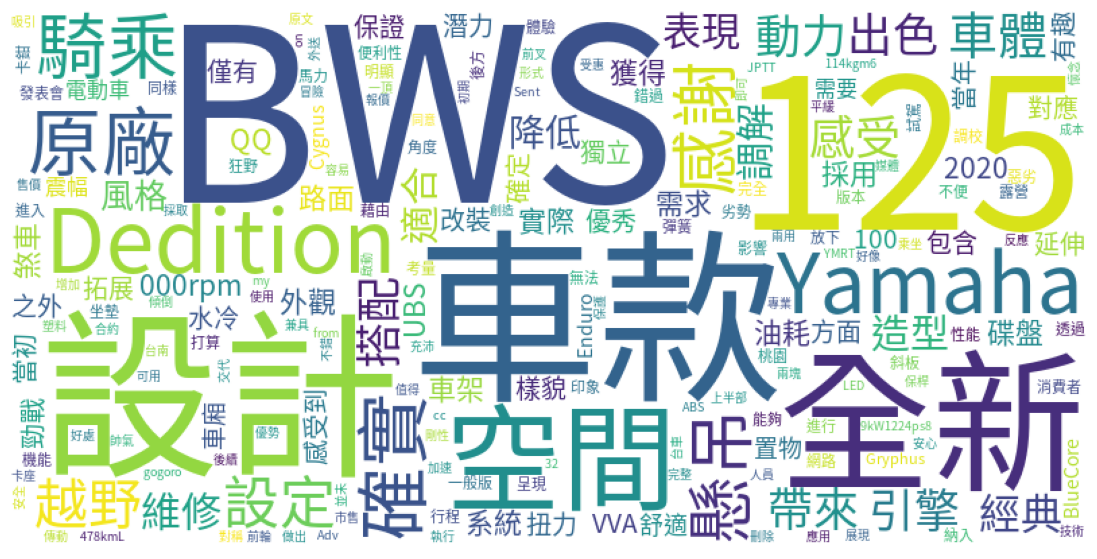

In [35]:
font_path = "rawData/SourceHanSansTW-Regular.otf"  # 中文字型路徑
# cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
# cloud.generate_from_frequencies(wc)

cloud = WordCloud(background_color='white',width=800, height = 400, font_path=font_path, max_words=200)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize = (14,7))
# plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud)
plt.axis("off")
# plt.show()

2020-10-30 是正面詞彙次數最高的一天。我們可以用文字雲來觀察，機車版在這天最常出現的正面情緒字有哪些。

C:\Users\collin\AppData\Local\Temp\ipykernel_17668\1533068079.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (


(-0.5, 799.5, 399.5, -0.5)

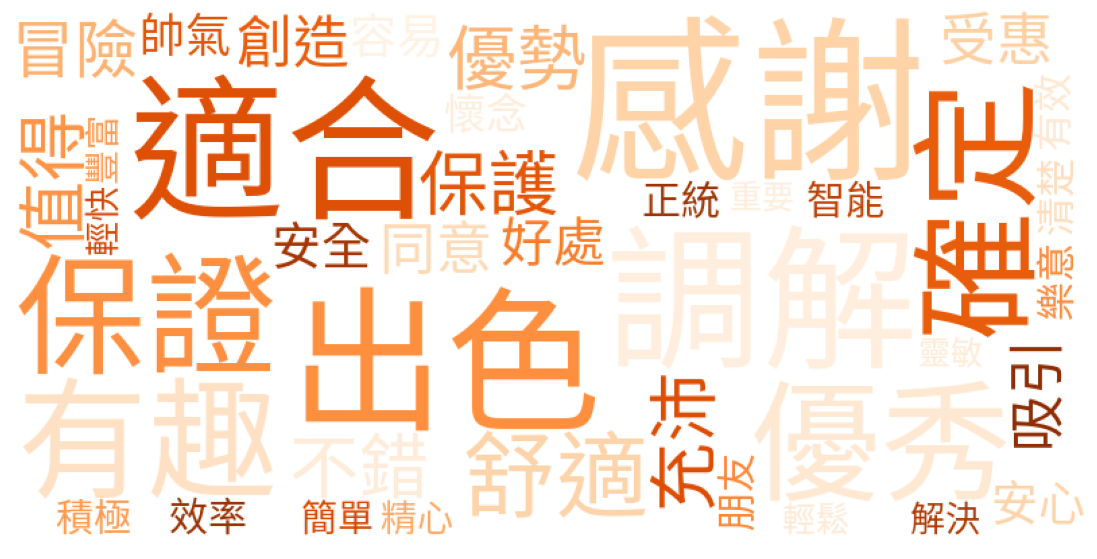

In [36]:
date = "2020-10-30"
mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"] == "positive"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "rawData/SourceHanSansTW-Regular.otf"  # 中文字型路徑
# cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="Oranges")
# cloud.generate_from_frequencies(wc)

cloud = WordCloud(background_color='white',width=800, height = 400, font_path=font_path, max_words=200, colormap="Oranges")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize = (14,7))
# plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud)
plt.axis("off")
# plt.show()

C:\Users\collin\AppData\Local\Temp\ipykernel_17668\1540206301.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (


(-0.5, 799.5, 399.5, -0.5)

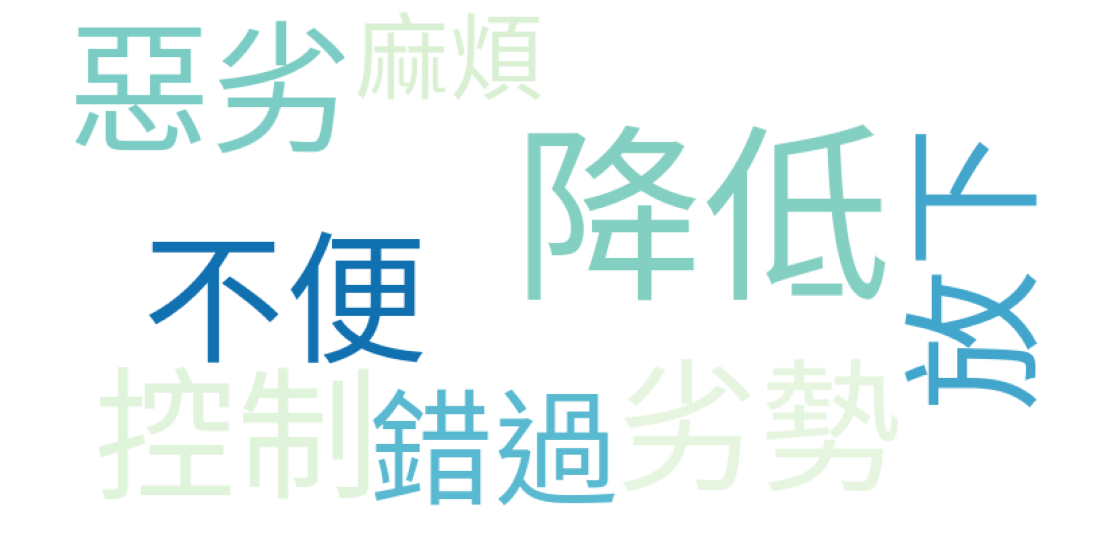

In [37]:
date = "2020-10-30"
mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"] == "negative"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "rawData/SourceHanSansTW-Regular.otf"  # 中文字型路徑
# cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
# cloud.generate_from_frequencies(wc)

cloud = WordCloud(background_color='white',width=800, height = 400, font_path=font_path, max_words=200, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize = (14,7))
# plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud)
plt.axis("off")
# plt.show()

### 3.6 情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [38]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

,word,sentiments,size
61,不錯,positive,449
60,不錯,affect,449
412,喜歡,positive,443
411,喜歡,affect,443
784,感謝,affect,409
...,...,...,...
838,打倒,affect,1
837,打仗,negative,1
836,打仗,anger,1
835,打仗,affect,1


In [39]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos

,word,sentiments,size
61,不錯,positive,449
412,喜歡,positive,443
785,感謝,positive,409
1058,朋友,positive,400
249,分享,positive,360
...,...,...,...
1414,神聖,positive,1
915,振奮,positive,1
1441,笑翻,positive,1
1482,結實,positive,1


In [40]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg

,word,sentiments,size
1903,麻煩,negative,233
1513,缺點,negative,198
962,擔心,negative,137
1766,違規,negative,129
427,嚴重,negative,126
...,...,...,...
852,打斷,negative,1
1445,笨拙,negative,1
849,打敗,negative,1
63,不靈,negative,1


In [39]:
word_of_neg.sort_values(
    ["size"], ascending=False
)

,word,sentiments,size
1903,麻煩,negative,233
1513,缺點,negative,198
962,擔心,negative,137
1766,違規,negative,129
427,嚴重,negative,126
...,...,...,...
1710,貪汙,negative,1
520,妨礙,negative,1
514,妄想,negative,1
1724,躲避,negative,1


C:\Users\collin\AppData\Local\Temp\ipykernel_17668\1433489422.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"])
C:\Users\collin\AppData\Local\Temp\ipykernel_17668\1433489422.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"])


Text(0.5, 1.0, '負向情緒總數')

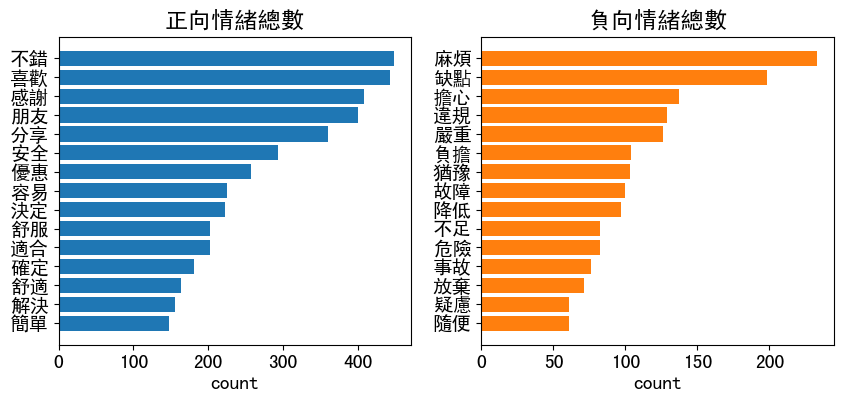

In [42]:
pos = word_of_pos.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]
neg = word_of_neg.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"])
ax[0].set_title("正向情緒總數")

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"])
ax[1].set_title("負向情緒總數")

#### 2021-01-27 正負情緒代表字 - negative

In [43]:
sentiment_count[sentiment_count["sentiments"] == "negative"].sort_values('size', ascending=False)

,artDate,sentiments,size,ratio
5094,2021-10-08,negative,34,0.057336
5718,2022-05-28,negative,26,0.040123
4352,2021-01-27,negative,26,0.016240
6260,2022-12-04,negative,23,0.045098
638,2017-07-13,negative,22,0.031977
...,...,...,...,...
686,2017-07-25,negative,1,0.032258
689,2017-07-26,negative,1,0.019231
4948,2021-08-28,negative,1,0.007576
1694,2018-08-29,negative,1,0.010638


In [44]:
date = '2021-01-27'
mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"].isin(['positive', 'negative'])
)

ptt_df_date = ptt_liwc_df.loc[mask, ["artDate", "word", "sentiments"]]
ptt_df_date_senti = ptt_df_date.groupby(["sentiments", "word"], as_index=False).size()
ptt_df_date_senti.head()

C:\Users\collin\AppData\Local\Temp\ipykernel_17668\421090581.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date)) & (


,sentiments,word,size
0,negative,危險,1
1,negative,壓抑,1
2,negative,惡性,1
3,negative,惡意,1
4,negative,控制,2


C:\Users\collin\AppData\Local\Temp\ipykernel_17668\1670547556.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"])
C:\Users\collin\AppData\Local\Temp\ipykernel_17668\1670547556.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"])


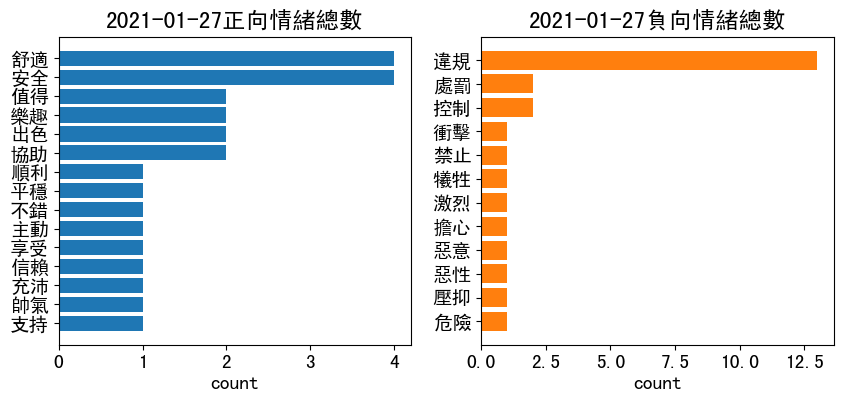

In [45]:
pos = ptt_df_date_senti[(ptt_df_date_senti["sentiments"] == "positive")].sort_values(
    ["size"], ascending=True
)
pos = pos[-15:]
neg = ptt_df_date_senti[ptt_df_date_senti["sentiments"] == "negative"].sort_values(
    ["size"], ascending=True
)
neg = neg[-15:]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_title(f"{date}正向情緒總數")
ax[0].set_yticklabels(pos["word"])

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_title(f"{date}負向情緒總數")
ax[1].set_yticklabels(neg["word"])
plt.show()

#### 2020-10-30 正負情緒代表字 - positive

In [46]:
sentiment_count[sentiment_count["sentiments"] == "positive"].sort_values('size', ascending=False)

,artDate,sentiments,size,ratio
3937,2020-09-20,positive,65,0.056868
4094,2020-10-30,positive,55,0.034396
4126,2020-11-06,positive,53,0.043983
1626,2018-08-07,positive,50,0.040617
1463,2018-06-25,positive,49,0.045455
...,...,...,...,...
1288,2018-01-16,positive,1,0.018182
5128,2021-10-19,positive,1,0.047619
5135,2021-10-21,positive,1,0.022727
1275,2018-01-12,positive,1,0.038462


In [47]:
date = '2020-10-30'
mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"].isin(['positive', 'negative'])
)

ptt_df_date = ptt_liwc_df.loc[mask, ["artDate", "word", "sentiments"]]
ptt_df_date_senti = ptt_df_date.groupby(["sentiments", "word"], as_index=False).size()
ptt_df_date_senti.head()

C:\Users\collin\AppData\Local\Temp\ipykernel_17668\3398094619.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date)) & (


,sentiments,word,size
0,negative,不便,1
1,negative,劣勢,1
2,negative,惡劣,1
3,negative,控制,1
4,negative,放下,1


C:\Users\collin\AppData\Local\Temp\ipykernel_17668\1670547556.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"])
C:\Users\collin\AppData\Local\Temp\ipykernel_17668\1670547556.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"])


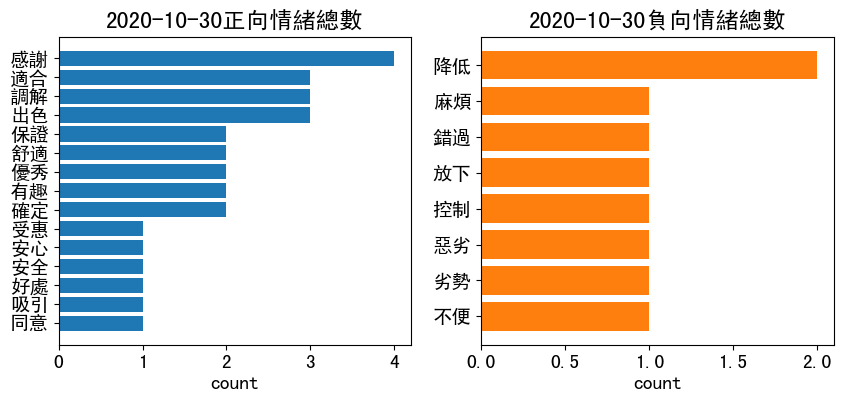

In [48]:
pos = ptt_df_date_senti[(ptt_df_date_senti["sentiments"] == "positive")].sort_values(
    ["size"], ascending=True
)
pos = pos[-15:]
neg = ptt_df_date_senti[ptt_df_date_senti["sentiments"] == "negative"].sort_values(
    ["size"], ascending=True
)
neg = neg[-15:]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_title(f"{date}正向情緒總數")
ax[0].set_yticklabels(pos["word"])

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_title(f"{date}負向情緒總數")
ax[1].set_yticklabels(neg["word"])
plt.show()

### 3.7 每日情緒分數趨勢

In [49]:
sentiment_count

,artDate,sentiments,size,ratio
0,2017-01-02,affect,8,0.041667
1,2017-01-02,negative,2,0.010417
2,2017-01-02,positive,5,0.026042
3,2017-01-02,NaN,177,0.921875
4,2017-01-03,affect,42,0.065523
...,...,...,...,...
6539,2023-03-29,anx,2,0.015504
6543,2023-03-29,NaN,107,0.829457
6545,2023-03-30,positive,1,0.007519
6544,2023-03-30,affect,2,0.015038


In [50]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

,artDate,affect,anger,anx,negative,positive,sad
0,2017-01-02,8,0,0,2,5,0
1,2017-01-03,42,2,3,6,16,0
2,2017-01-04,10,0,0,3,6,0
3,2017-01-05,1,0,0,1,0,1
4,2017-01-06,1,0,1,1,0,0


In [51]:
# sentiment 計算方式: positive - anger - anx - negative - sad
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["anger"]
    - ptt_sentiment_value["anx"]
    - ptt_sentiment_value["negative"]
    - ptt_sentiment_value["sad"]
)
ptt_sentiment_value.head()

,artDate,affect,anger,anx,negative,positive,sad,sentiment_value
0,2017-01-02,8,0,0,2,5,0,3
1,2017-01-03,42,2,3,6,16,0,5
2,2017-01-04,10,0,0,3,6,0,3
3,2017-01-05,1,0,0,1,0,1,-2
4,2017-01-06,1,0,1,1,0,0,-2


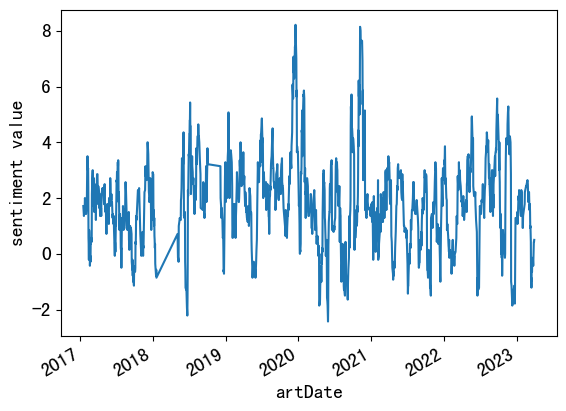

In [52]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()

## 4. lexicon-base 情緒分析2

引入所需套件

In [53]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io
from wordcloud import WordCloud, ImageColorGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

### 4.1 CKIP 安裝

In [54]:
#data_utils.download_data_gdown("./") # gdrive-ckip # 下載ckip model

In [55]:
# 將三份工具的模型路徑指向我們剛才下載的 data.zip
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

c:\Users\collin\anaconda3\envs\social_media\lib\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\collin\anaconda3\envs\social_media\lib\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\collin\anaconda3\envs\social_media\lib\site-packages\ckiptagger\model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell =

定義文字清理相關function

In [56]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#     paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), str(article).split("\n")))
#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

In [57]:
# 自定義辭典
with open('dict/user_dict.txt') as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)

[(4, {'電動機車': 100.0})]


In [58]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary 
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'],sentence])            
            temp_tokens = get_pos(row['system_id'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [59]:
# 看看tmp和flat_list有什麼差別
tmp = Sentence_Segmentation(df['artContent'][0]) 
flat_list = [item for sublist in tmp for item in sublist]
print(tmp[:5])
print(flat_list[:5])

[['若僅為新車問題或心得文章者則不需此範本，請自行刪除所有內容'], ['欲比較車種時，請在標題打上車種名稱', '如/新勁戰/'], ['請勿使用"請問新車""請推薦車"等過於模糊不方便搜尋的標題'], ['請自行刪除以上補充'], []]
['若僅為新車問題或心得文章者則不需此範本，請自行刪除所有內容', '欲比較車種時，請在標題打上車種名稱', '如/新勁戰/', '請勿使用"請問新車""請推薦車"等過於模糊不方便搜尋的標題', '請自行刪除以上補充']


In [60]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

time costing: 1075.751297712326


In [61]:
pos_table.head() # word pos 列表

,system_id,word,pos
0,1,若,Cbb
1,1,僅,Da
2,1,為,VG
3,1,新,VH
4,1,車,Na


In [62]:
entity_table.head() # word entity 列表

,system_id,word,ner
0,1,雲豹,PERSON
1,1,四,CARDINAL
2,1,雲豹,PERSON
3,1,台中,GPE
4,2,這兩天,DATE


In [63]:
sentence_table.head()

,system_id,sentence
0,1,若僅為新車問題或心得文章者則不需此範本，請自行刪除所有內容
1,1,欲比較車種時，請在標題打上車種名稱
2,1,如/新勁戰/
3,1,"請勿使用""請問新車""""請推薦車""等過於模糊不方便搜尋的標題"
4,1,請自行刪除以上補充


In [64]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # 1517篇文
print(f"posts have NER: {len(entity_table['system_id'].unique())}") # 1349篇有抓到ner

total posts numbers: 2731
posts have NER: 2424


In [65]:
# 將文章存成csv
pos_table.to_csv('rawData/pos_table_motor.csv', index = False)
entity_table.to_csv('rawData/entity_table_motor.csv', index = False)
sentence_table.to_csv('rawData/sentence_table_motor.csv', index = False)

### 4.2 探索分析 - NER

將剛才分析的資料匯入

In [66]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("rawData/pos_table_motor.csv") 
entity_table = pd.read_csv("rawData/entity_table_motor.csv") 
sentence_table = pd.read_csv("rawData/sentence_table_motor.csv") 

### NER 種類分析
查看標註這個文集後辨識出哪一些實體種類<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [67]:
entity_table['ner'].unique()

array(['PERSON', 'CARDINAL', 'GPE', 'DATE', 'ORG', 'TIME', 'FAC', 'LOC',
       'QUANTITY', 'PERCENT', 'MONEY', 'NORP', 'ORDINAL', 'PRODUCT',
       'WORK_OF_ART', 'EVENT', 'LANGUAGE', 'LAW'], dtype=object)

In [68]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(8)
ner_count

,ner,count
1,DATE,3827
0,CARDINAL,3750
4,GPE,2316
11,ORG,1893
13,PERSON,1755
10,ORDINAL,622
16,TIME,592
8,MONEY,452


C:\Users\collin\AppData\Local\Temp\ipykernel_17668\3390866936.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


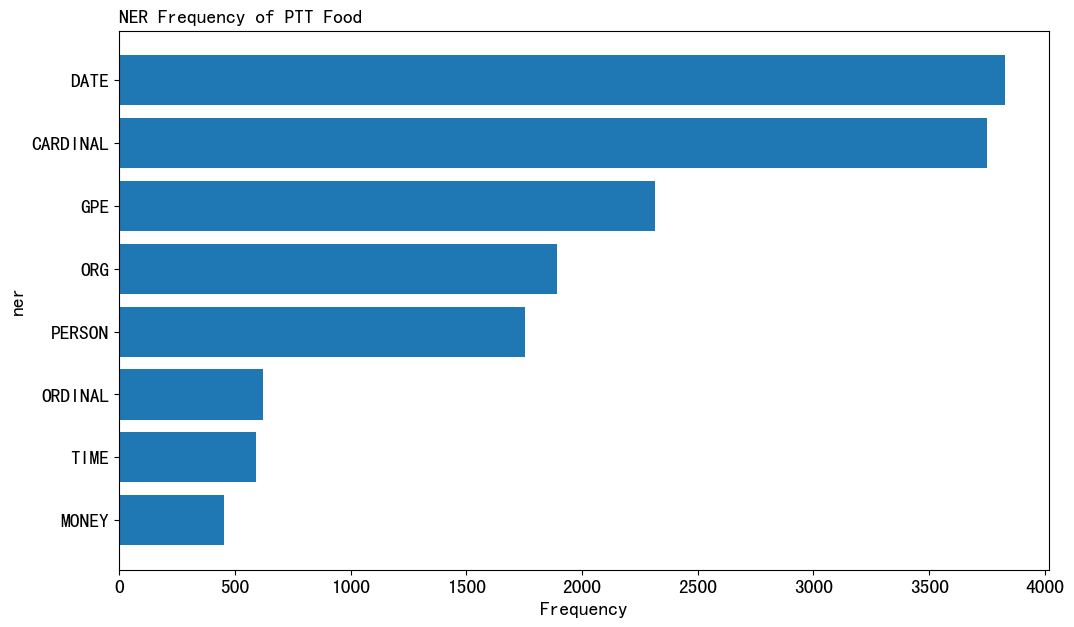

In [69]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Food',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的人名(PERSON)

C:\Users\collin\AppData\Local\Temp\ipykernel_17668\2044175467.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


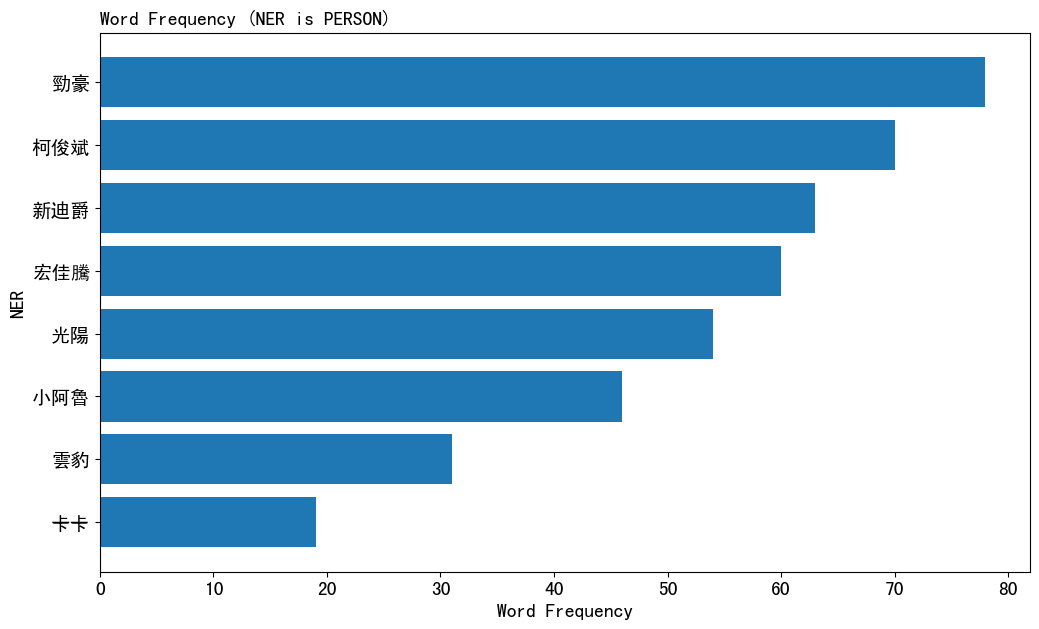

In [70]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 涉及到的組織(ORG)

C:\Users\collin\AppData\Local\Temp\ipykernel_17668\3690618897.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


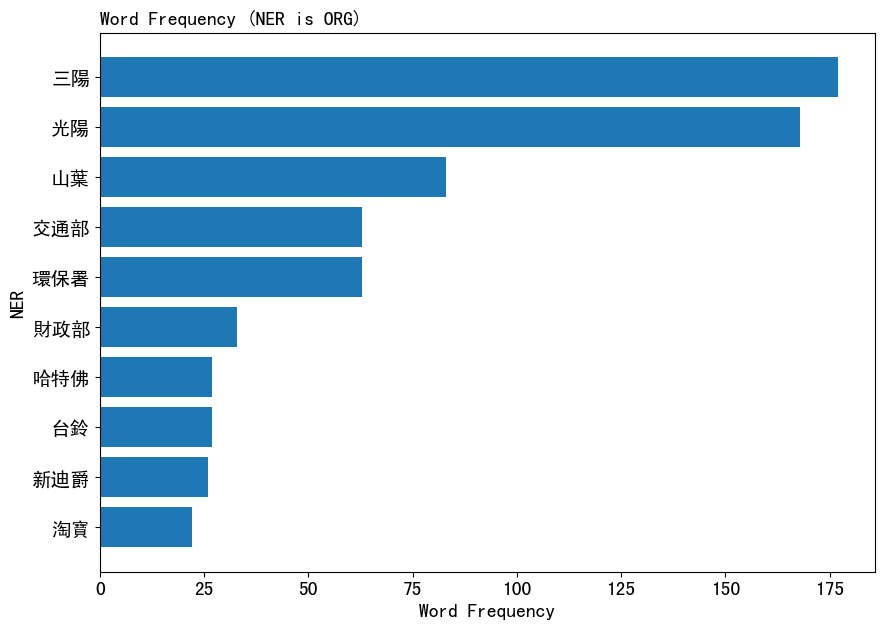

In [71]:
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 涉及到的民族、宗教、政治團體(NORP)

C:\Users\collin\AppData\Local\Temp\ipykernel_17668\1258504230.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


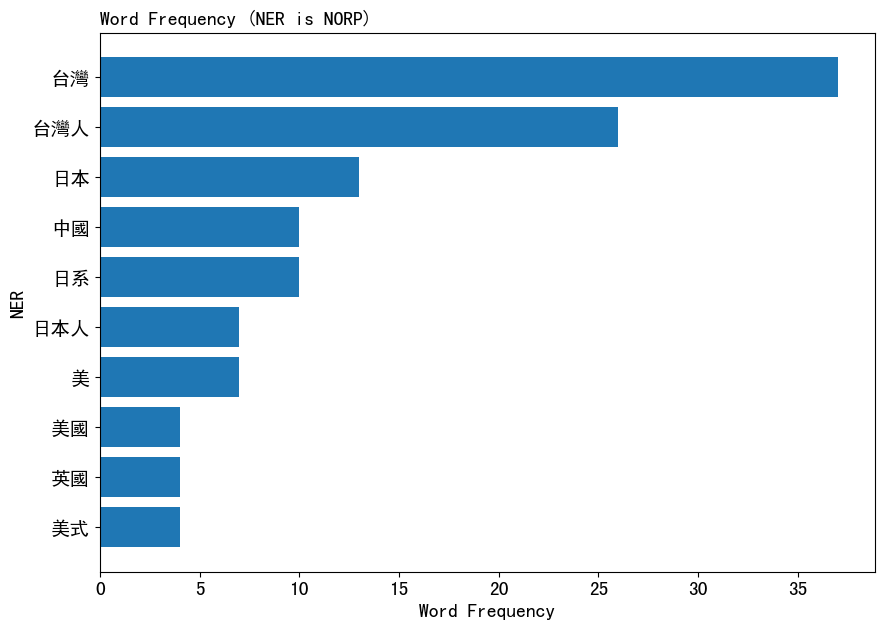

In [72]:
# 篩選ner為名詞的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [87]:
keyword_list = ['gogoro']
thailand_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True, na=False)]
print(f"{' '.join(keyword_list)}：{thailand_selected.shape[0]}篇相關貼文")
thailand_selected.head(3)

gogoro：70篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
20,21,https://www.ptt.cc/bbs/biker/M.1483879737.A.98...,Re:[閒聊]GOGORO的趨勢？,2017-01-08 12:42:55,t9441006,biker,安安各位\r\n我是gogoro的校園大使\r\n但我不是gogoro的員工，所以也沒有利益...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""aalittle"", ""...",27.247.11.42,2018-04-29 07:05:28,ptt
244,245,https://www.ptt.cc/bbs/biker/M.1496335457.A.2F...,[新車]gogoro2/新競戰,2017-06-01 16:38:14,batista5288,biker,───────────────────────────────────────\r\n\r\...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""imyc"", ""cmtC...",1.160.130.40,2018-04-29 07:07:07,ptt
433,434,https://www.ptt.cc/bbs/biker/M.1505284283.A.A5...,[新車])新迪爵/勁豪/gogoro2,2017-09-13 06:25:21,irebecca,biker,《是否已閱讀置底文章『[新車] 2012主流車種比較』》\r\n\r\n Yes /但是...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""a60130chen"",...",59.115.90.212,2018-04-29 07:08:13,ptt


### 4.3 探索分析 - POS

#### POS 種類分析
查看辨識出哪幾種POS<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [88]:
pos_table['pos'].unique()

array(['Cbb', 'Da', 'VG', 'VH', 'Na', 'Caa', 'D', 'Nep', 'COMMACATEGORY',
       'VF', 'VC', 'Neqa', 'VK', 'Ng', 'P', 'FW', 'VE', 'Cab', 'Dfa',
       'DE', 'Ncd', 'Nc', 'Nd', 'A', 'Nh', 'VJ', 'V_2', 'SHI', 'T', 'Cba',
       'Nf', 'Neu', 'VD', 'VAC', 'Di', 'VA', 'VCL', 'COLONCATEGORY',
       'Nes', 'VB', 'VHC', 'Nb', 'Nv', 'VL', 'DM', 'Dfb', 'Dk', 'Neqb',
       'VI', 'I', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'DASHCATEGORY',
       'ETCCATEGORY', 'PAUSECATEGORY', 'EXCLAMATIONCATEGORY',
       'SPCHANGECATEGORY'], dtype=object)

看看除了標點符號，大部分的POS都是哪一類

In [89]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

,pos,count
18,Na,117907
5,D,74137
40,VC,53767
46,VH,39285
7,DE,25046
32,P,19396
43,VE,16874
4,Cbb,16481
30,Nh,16048
28,Nf,15849


C:\Users\collin\AppData\Local\Temp\ipykernel_17668\2478466374.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


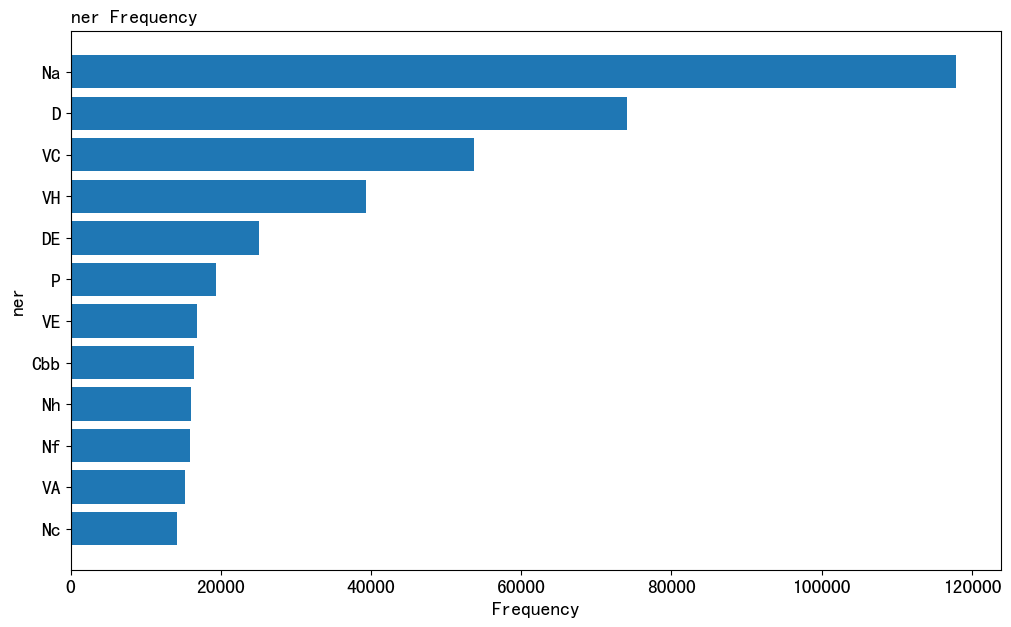

In [90]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的名詞(Noun)
+ 我們可以找出談論吃到飽時大部分討論到的專有名詞，探索大家的關注焦點。
+ 名詞可以分為「Na: 普通名詞」、「Nb: 專有名詞」等

In [91]:
# 篩選pos為名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

,word,count
120,光陽,598
20,三陽,255
156,勁戰,189
948,迪爵,166
386,山葉,144
158,勁豪,94
686,火星,90
336,宏佳騰,85
511,新迪爵,84
1065,阿魯,70


C:\Users\collin\AppData\Local\Temp\ipykernel_17668\502700507.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


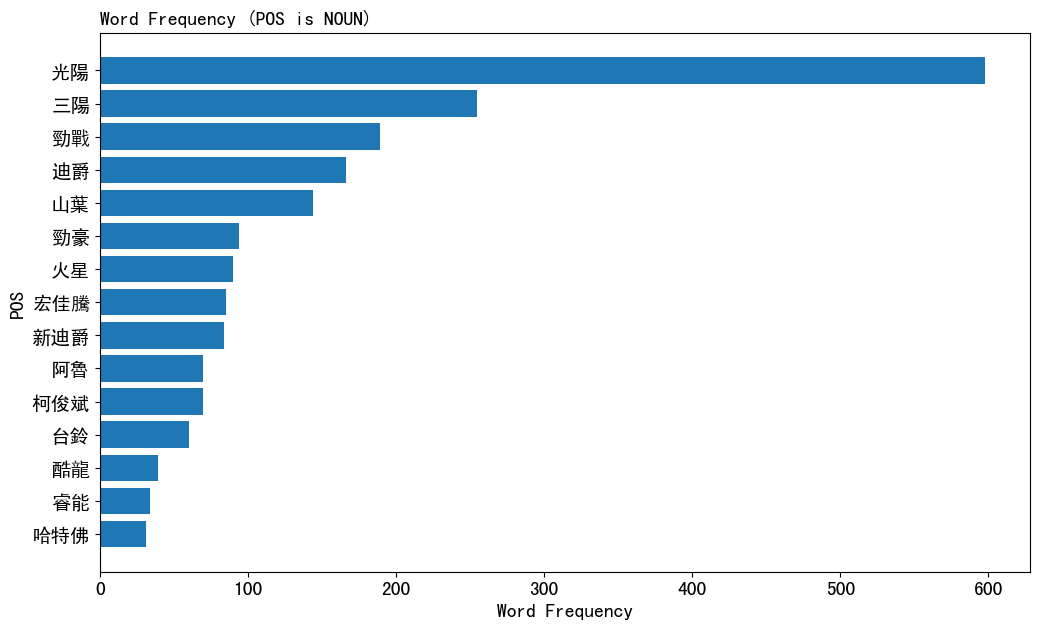

In [92]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 涉及到的動詞(VERB)
+ 我們可以找出談論吃到飽時大部分討論到的動詞，探索相關行為。
+ VC: 動作及物動詞、VH: 狀態不及物動詞、VA: 動作不及物動詞

In [93]:
l_verb = ["VC"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

,word,count
3523,購買,1066
1707,推薦,822
159,使用,794
3168,補充,671
2310,比較,594
4130,騎乘,524
2705,看過,522
186,保養,458
2208,更換,395
2902,維修,393


C:\Users\collin\AppData\Local\Temp\ipykernel_17668\1955970811.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


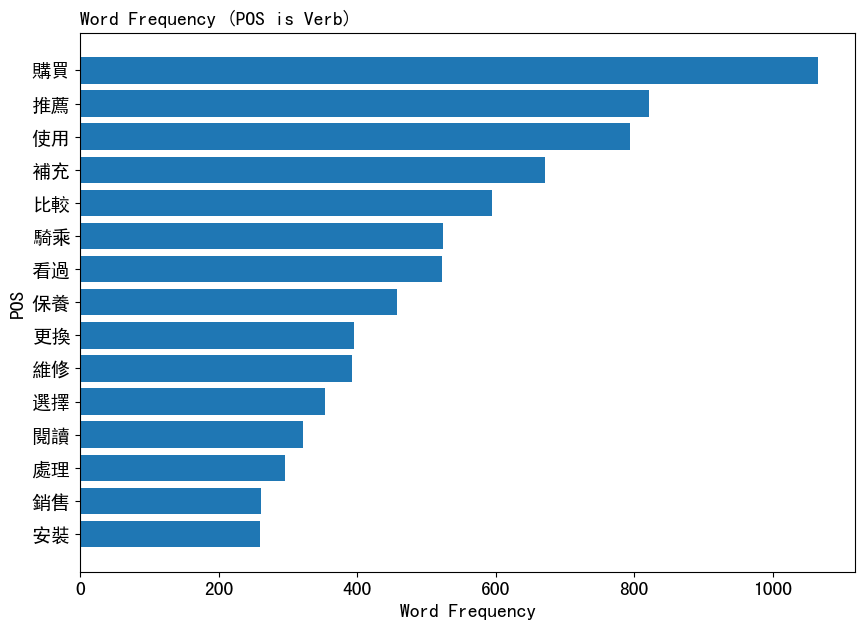

In [94]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is Verb)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

## 5. 利用SnowNLP進行情緒分析

In [95]:
from snownlp import SnowNLP

In [96]:
sentence_table = pd.read_csv("rawData/sentence_table_motor.csv") #匯資料

sentiment_date = pd.merge(sentence_table,thailand_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head()

,system_id,sentence,artDate,dataSource
342,21,安安各位,2017-01-08 12:42:55,ptt
343,21,我是的校園大使,2017-01-08 12:42:55,ptt
344,21,但我不是的員工，所以也沒有利益關係,2017-01-08 12:42:55,ptt
345,21,之前在板上問了很多問題,2017-01-08 12:42:55,ptt
346,21,我想是時候也來回答下了,2017-01-08 12:42:55,ptt


In [97]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head()

,system_id,sentence,artDate,dataSource,sentimentValue
342,21,安安各位,2017-01-08 12:42:55,ptt,0.916667
343,21,我是的校園大使,2017-01-08 12:42:55,ptt,0.981650
344,21,但我不是的員工，所以也沒有利益關係,2017-01-08 12:42:55,ptt,0.823397
345,21,之前在板上問了很多問題,2017-01-08 12:42:55,ptt,0.012054
346,21,我想是時候也來回答下了,2017-01-08 12:42:55,ptt,0.068940


In [98]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    1.872000e+03
mean     3.713976e-01
std      3.078833e-01
min      8.620458e-07
25%      8.118615e-02
50%      2.971987e-01
75%      6.008443e-01
max      9.999896e-01
Name: sentimentValue, dtype: float64

<Axes: >

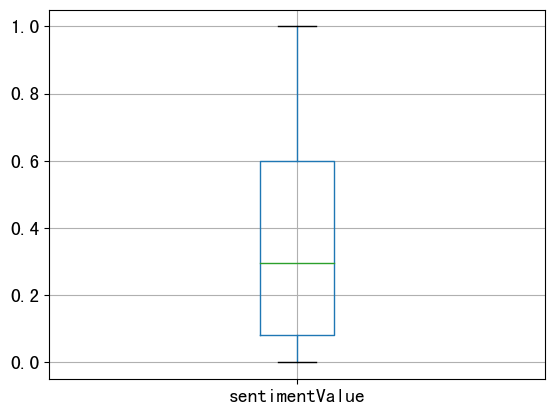

In [99]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

In [145]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

,artDate,sentimentValue
0,2017-01,0.477205
1,2017-06,0.387718
2,2017-09,0.477475
3,2017-10,0.307229
4,2017-11,0.379471
5,2018-01,0.372108
6,2018-05,0.247514
7,2018-08,0.373312
8,2018-09,0.286260
9,2019-03,0.440056


C:\Users\collin\AppData\Local\Temp\ipykernel_17668\2520951907.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


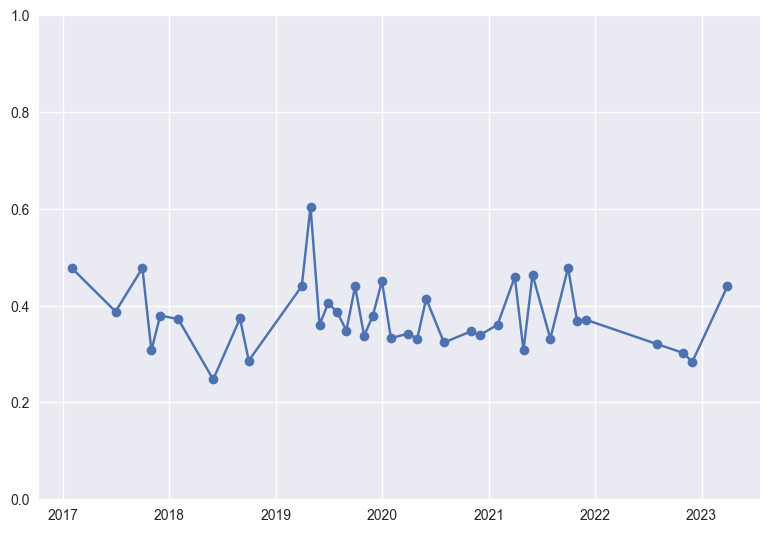

In [131]:
plt.style.use('seaborn')

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

### 詞彙探索
從上圖中可以發現 2019年4月的情緒分數相對高，我們把這個月的正面句子挑出來看看他們都用甚麼詞。

In [147]:
filter_sentiment = sent_date[sent_date['artDate']=='2019-04']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] > 0.6]

filter_sentiment.head()

,system_id,sentence,artDate,dataSource,sentimentValue
21040,1034,現在約騎萬初頭公里了,2019-04,ptt,0.937219
21041,1034,現在曲軸壞了，修要約萬，車行估車價約萬,2019-04,ptt,0.898929
21042,1034,現在在猶豫要修車,2019-04,ptt,0.781453
21045,1034,生活圈都在大台北地區，假日偶爾騎去郊區逛逛,2019-04,ptt,0.934595


In [148]:
# 把時間分數和之前斷詞的token table做 join
neg_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
neg_words = neg_words[['system_id','sentimentValue','word']]
neg_words.head()

,system_id,sentimentValue,word
0,1034,0.937219,小弟
1,1034,0.937219,現在
2,1034,0.937219,騎勁戰
3,1034,0.937219,四
4,1034,0.937219,代


In [149]:
# 篩選掉只有單個字元的結果
neg_words = neg_words[neg_words.apply(lambda x: len(x['word'])>1, axis=1)]

### 正面詞彙文字雲

In [150]:
# 自定停用字
with open('dict/stopwords.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words)

['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”', '、', '。', '《', '》', '一', '一些', '一何', '一切', '一則', '一方面', '一旦', '一來', '一樣', '一般', '一轉眼', '萬一', '上', '上下', '下', '不', '不僅', '不但', '不光', '不單', '不只', '不外乎', '不如', '不妨', '不盡', '不盡然', '不得', '不怕', '不惟', '不成', '不拘', '不料', '不是', '不比', '不然', '不特', '不獨', '不管', '不至於', '不若', '不論', '不過', '不問', '與', '與其', '與其說', '與否', '與此同時', '且', '且不說', '且說', '兩者', '個', '個別', '臨', '為', '為了', '為什麼', '為何', '為止', '為此', '為著', '乃', '乃至', '乃至於', '麼', '之', '之一', '之所以', '之類', '烏乎', '乎', '乘', '也', '也好', '也罷', '了', '二來', '於', '於是', '於是乎', '云云', '云爾', '些', '亦', '人', '人們', '人家', '什麼', '什麼樣', '今', '介於', '仍', '仍舊', '從', '從此', '從而', '他', '他人', '他們', '以', '以上', '以為', '以便', '以免', '以及', '以故', '以期', '以來', '以至', '以至於', '以致', '們', '任', '任何', '任憑', '似的', '但', '但凡', '但是', '何', '何以', '何況', '何處', '何時', '余外', '作為', '你', '你們', '使', '使得', '例如', '依', '依據', '依照', '便於', '俺', '俺們', '倘', '倘使', '倘或', '倘然', '倘若', '借', '假使', '假如', '假若', '儻然', '像', '兒', '先不先', '光是', '全體', '全部', '

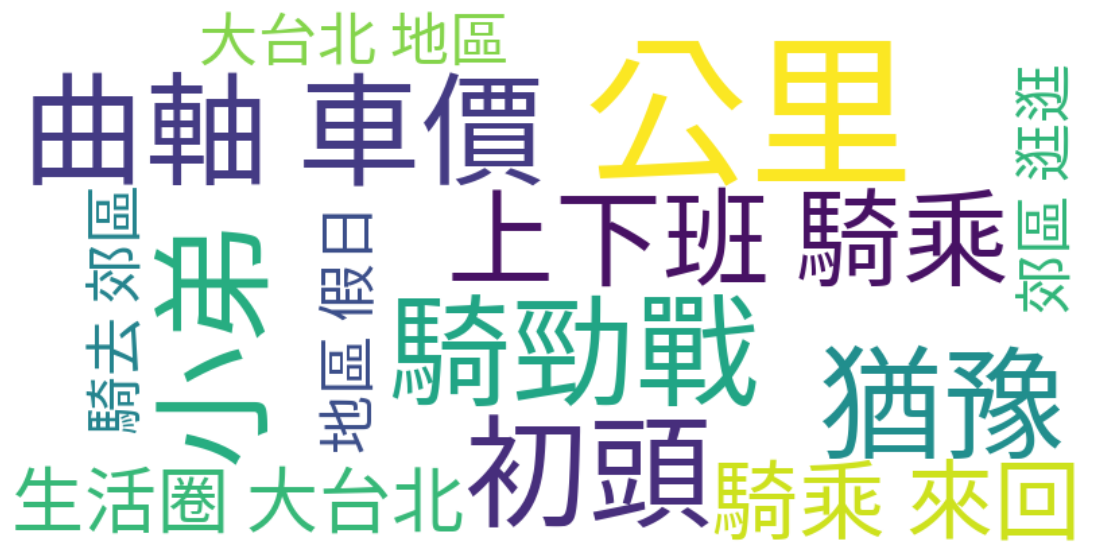

In [151]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(("謝謝", "一下", "問題", "感覺", "目前", "請問", "發現", "直接", "知道", "看到", "現在", "車子", "建議", "車主", "希望", "10", "一點"))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")

wordcloud.generate(' '.join(neg_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

#### 看 Gogoro 的討論趨勢

# TF-IDF

### 計算每篇文章的總詞彙數與各個詞彙數

In [54]:
MetaData = df.copy()
MetaData.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,『若僅為新車問題或心得文章者則不需此範本』，請自行刪除所有內容。\r\n\r\n 欲比較車...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt
1,2,https://www.ptt.cc/bbs/biker/M.1483383716.A.A3...,[討論]霧季到霧中行車該注意什麼?,2017-01-02 18:55:52,FECer,biker,這一兩天西部地區都有濃霧出現\r\n\r\n看到板上以前的文中有提到幾個在霧中行車該注意的\...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""blackhippo"",...",125.224.210.237,2018-04-29 07:05:28,ptt
2,3,https://www.ptt.cc/bbs/biker/M.1483416557.A.31...,[閒聊]白牌小車被逼車過的請進,2017-01-03 04:03:14,Haooconnor,biker,大家好，小弟我發這篇文不是來討拍，我想請問各位大大有沒有遇過惡劣的駕\r\n駛任意變換車道、...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Davil0130"", ...",223.141.199.140,2018-04-29 07:05:28,ptt
3,4,https://www.ptt.cc/bbs/biker/M.1483420431.A.5C...,[問題]請問這台二手SYMGT該下手嗎,2017-01-03 05:07:46,J0825N,biker,最近朋友有台車想賣\r\n\r\n是2014年出廠的SYM GT125\r\n\r\n車況滿...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""blackyy"", ""c...",101.12.103.223,2018-04-29 07:05:28,ptt
4,5,https://www.ptt.cc/bbs/biker/M.1483461332.A.DD...,Fw:[合作]《PTT聯合*書寶》年終公益募集活動,2017-01-03 16:29:31,Derek324kimo,biker,作者: tencc2871 (莫) 看板: BB_Book2017\r\n標題: [合作] ...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""samhou6"", ""c...",123.194.128.204,2018-04-29 07:05:28,ptt


In [57]:
# 移除網址格式
MetaData['sentence'] = MetaData.artContent.apply(lambda x: re.sub('(http|https)://.*', '', str(x)))
# 只留下中文字
MetaData['sentence'] = MetaData.artContent.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '',str(x)))
MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,『若僅為新車問題或心得文章者則不需此範本』，請自行刪除所有內容。\r\n\r\n 欲比較車...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,若僅為新車問題或心得文章者則不需此範本請自行刪除所有內容欲比較車種時請在標題打上車種名稱如新...
1,2,https://www.ptt.cc/bbs/biker/M.1483383716.A.A3...,[討論]霧季到霧中行車該注意什麼?,2017-01-02 18:55:52,FECer,biker,這一兩天西部地區都有濃霧出現\r\n\r\n看到板上以前的文中有提到幾個在霧中行車該注意的\...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""blackhippo"",...",125.224.210.237,2018-04-29 07:05:28,ptt,這一兩天西部地區都有濃霧出現看到板上以前的文中有提到幾個在霧中行車該注意的放慢車速外機車也沒...
2,3,https://www.ptt.cc/bbs/biker/M.1483416557.A.31...,[閒聊]白牌小車被逼車過的請進,2017-01-03 04:03:14,Haooconnor,biker,大家好，小弟我發這篇文不是來討拍，我想請問各位大大有沒有遇過惡劣的駕\r\n駛任意變換車道、...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Davil0130"", ...",223.141.199.140,2018-04-29 07:05:28,ptt,大家好小弟我發這篇文不是來討拍我想請問各位大大有沒有遇過惡劣的駕駛任意變換車道急煞的經驗目前...


In [59]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [60]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [61]:
data = MetaData.copy()
data['word'] = data.sentence.apply(getToken)

# 將word欄位展開
data = data.explode('word')

data.head(3)

Building prefix dict from c:\Users\collin\Desktop\socialMedia_project\dict\dict.txt.big ...
Loading model from cache C:\Users\collin\AppData\Local\Temp\jieba.u0caaf84a2321cd627dbb38b2e15eb981.cache
Loading model cost 0.841 seconds.
Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,『若僅為新車問題或心得文章者則不需此範本』，請自行刪除所有內容。\r\n\r\n 欲比較車...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,若僅為新車問題或心得文章者則不需此範本請自行刪除所有內容欲比較車種時請在標題打上車種名稱如新...,若僅
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,『若僅為新車問題或心得文章者則不需此範本』，請自行刪除所有內容。\r\n\r\n 欲比較車...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,若僅為新車問題或心得文章者則不需此範本請自行刪除所有內容欲比較車種時請在標題打上車種名稱如新...,新車
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,『若僅為新車問題或心得文章者則不需此範本』，請自行刪除所有內容。\r\n\r\n 欲比較車...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,若僅為新車問題或心得文章者則不需此範本請自行刪除所有內容欲比較車種時請在標題打上車種名稱如新...,問題


In [62]:
# 每篇文章的總詞彙數
total_words = data.groupby(['artUrl'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,artUrl,total
0,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,20
1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,141
2,https://www.ptt.cc/bbs/biker/M.1483383716.A.A3...,42
3,https://www.ptt.cc/bbs/biker/M.1483416557.A.31...,65
4,https://www.ptt.cc/bbs/biker/M.1483420431.A.5C...,49
...,...,...
2727,https://www.ptt.cc/bbs/biker/M.1680008773.A.01...,78
2728,https://www.ptt.cc/bbs/biker/M.1680053137.A.3E...,35
2729,https://www.ptt.cc/bbs/biker/M.1680099669.A.07...,87
2730,https://www.ptt.cc/bbs/biker/M.1680108698.A.B8...,62


In [63]:
# 計算各詞彙在各文章中出現的次數
word_count = data.groupby(['artUrl','word'],as_index=False).size()
word_count.rename(columns={'size': 'count'}, inplace=True)
word_count

,artUrl,word,count
0,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,一直,1
1,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,不用,1
2,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,二手,1
3,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,停樓,1
4,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,停車場,1
...,...,...,...
218965,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,較差,1
218966,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,運動性,2
218967,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,運轉,1
218968,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,過往,1


In [64]:
moto_words = word_count.merge(total_words,on = 'artUrl',how = 'left')
moto_words

,artUrl,word,count,total
0,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,一直,1,20
1,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,不用,1,20
2,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,二手,1,20
3,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,停樓,1,20
4,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,停車場,1,20
...,...,...,...,...
218965,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,較差,1,55
218966,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,運動性,2,55
218967,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,運轉,1,55
218968,https://www.ptt.cc/bbs/biker/M.1680132484.A.42...,過往,1,55


### 計算tf-idf值

In [65]:
# 計算tf
moto_words_tf_idf = moto_words.assign(tf = moto_words.iloc[:,2]/moto_words.iloc[:,3])
moto_words_tf_idf.head()

,artUrl,word,count,total,tf
0,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,一直,1,20,0.05
1,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,不用,1,20,0.05
2,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,二手,1,20,0.05
3,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,停樓,1,20,0.05
4,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,停車場,1,20,0.05


In [66]:
# 計算每個詞彙出現在幾篇文章中
idf_df = moto_words.groupby(['word'],as_index=False).size()
moto_words_tf_idf = moto_words_tf_idf.merge(idf_df,on = 'word',how = 'left')
moto_words_tf_idf.head()

,artUrl,word,count,total,tf,size
0,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,一直,1,20,0.05,321
1,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,不用,1,20,0.05,227
2,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,二手,1,20,0.05,620
3,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,停樓,1,20,0.05,1
4,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,停車場,1,20,0.05,37


In [67]:
# 計算idf
food_words_tf_idf = moto_words_tf_idf.assign(idf = moto_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

food_words_tf_idf = food_words_tf_idf.drop(labels=['size'],axis=1)
food_words_tf_idf.head()

,artUrl,word,count,total,tf,idf
0,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,一直,1,20,0.05,0.929976
1,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,不用,1,20,0.05,1.080455
2,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,二手,1,20,0.05,0.644089
3,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,停樓,1,20,0.05,3.436481
4,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,停車場,1,20,0.05,1.868279


In [68]:
# 計算tf*idf
moto_words_tf_idf = moto_words_tf_idf.assign(tf_idf = moto_words_tf_idf.iloc[:,4] * moto_words_tf_idf.iloc[:,5])
moto_words_tf_idf.head()

,artUrl,word,count,total,tf,size,tf_idf
0,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,一直,1,20,0.05,321,16.05
1,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,不用,1,20,0.05,227,11.35
2,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,二手,1,20,0.05,620,31.00
3,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,停樓,1,20,0.05,1,0.05
4,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,停車場,1,20,0.05,37,1.85


In [69]:
# 選出每篇文章，tf-idf值最大的前五個詞
group = moto_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(5, "tf_idf"))
group

artUrl  \
artUrl                                                                                                         
https://www.ptt.cc/bbs/biker/M.1457017502.A.6A5... 5       https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...   
                                                   13      https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...   
                                                   14      https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...   
                                                   2       https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...   
                                                   0       https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...   
...                                                                                                      ...   
https://www.ptt.cc/bbs/biker/M.1680132484.A.42A... 218961  https://www.ptt.cc/bbs/biker/M.1680132484.A.42...   
                                                   218949  https://www.ptt.cc/bbs/biker/M.1680132484.A.42...   
                                                   218932  https://www.ptt.cc/bbs/biker/M.1680132484.A.42...   
                                                   218959  https://www.ptt.cc/bbs/biker/M.1680132484.A.42...   
                                                   218954  https://www.ptt.cc/bbs/biker/M.1680132484.A.42...   

                                                          word  count  total  \
artUrl                                                                         
https://www.ptt.cc/bbs/biker/M.1457017502.A.6A5... 5        問題      1     20   
                                                   13       請問      1     20   
                                                   14       謝謝      1     20   
                                                   2        二手      1     20   
                                                   0        一直      1     20   
...                                                        ...    ...    ...   
https://www.ptt.cc/bbs/biker/M.1680132484.A.42A... 218961   請問      2     55   
                                                   218949   最近      1     55   
                                                   218932   二手      1     55   
                                                   218959   行車      3     55   
                                                   218954   發現      1     55   

                                                                 tf  size  \
artUrl                                                                      
https://www.ptt.cc/bbs/biker/M.1457017502.A.6A5... 5       0.050000   952   
                                                   13      0.050000   671   
                                                   14      0.050000   637   
                                                   2       0.050000   620   
                                                   0       0.050000   321   
...                                                             ...   ...   
https://www.ptt.cc/bbs/biker/M.1680132484.A.42A... 218961  0.036364   671   
                                                   218949  0.018182   699   
                                                   218932  0.018182   620   
                                                   218959  0.054545   191   
                                                   218954  0.018182   470   

                                                              tf_idf  
artUrl                                                                
https://www.ptt.cc/bbs/biker/M.1457017502.A.6A5... 5       47.600000  
                                                   13      33.550000  
                                                   14      31.850000  
                                                   2       31.000000  
                                                   0       16.050000  
...                                                              ...  
https://www.ptt.cc/bbs/biker/M.168

In [70]:
group.loc[:,["word","tf_idf"]][0:15]

word     tf_idf
artUrl                                                                
https://www.ptt.cc/bbs/biker/M.1457017502.A.6A5... 5     問題  47.600000
                                                   13    請問  33.550000
                                                   14    謝謝  31.850000
                                                   2     二手  31.000000
                                                   0     一直  16.050000
https://www.ptt.cc/bbs/biker/M.1483368284.A.9AE... 72    新車  14.489362
                                                   25    二手  13.191489
                                                   65    推薦   8.496454
                                                   97    補充   8.170213
                                                   44    問題   6.751773
https://www.ptt.cc/bbs/biker/M.1483383716.A.A34... 147   機車  19.309524
                                                   151   看到  13.119048
                                                   129   一點   9.547619
                                                   152   行車   9.095238
                                                   148   注意   8.095238

In [71]:
# 從每篇文章挑選出tf-idf最大的前十個詞
(moto_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) # 排序看前十名

,word,size
205,問題,944
596,目前,856
791,車行,853
758,購買,828
500,機車,772
608,知道,721
0,一下,678
469,最近,650
439,新車,627
732,請問,619


## 透過結巴斷詞與N-gram幫助建立字典

In [72]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [77]:
moto_bigram = MetaData.copy()

moto_bigram["word"] = moto_bigram.sentence.apply(bigram_getToken)
moto_bigram = moto_bigram.explode('word')
moto_bigram.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,『若僅為新車問題或心得文章者則不需此範本』，請自行刪除所有內容。\r\n\r\n 欲比較車...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,若僅為新車問題或心得文章者則不需此範本請自行刪除所有內容欲比較車種時請在標題打上車種名稱如新...,若僅 新車
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,『若僅為新車問題或心得文章者則不需此範本』，請自行刪除所有內容。\r\n\r\n 欲比較車...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,若僅為新車問題或心得文章者則不需此範本請自行刪除所有內容欲比較車種時請在標題打上車種名稱如新...,新車 問題
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,『若僅為新車問題或心得文章者則不需此範本』，請自行刪除所有內容。\r\n\r\n 欲比較車...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,若僅為新車問題或心得文章者則不需此範本請自行刪除所有內容欲比較車種時請在標題打上車種名稱如新...,問題 心得


### 統計最常出現的bigram組合

In [78]:
# 計算每個組合出現的次數
food_bigram_count = food_bigram.groupby(["word"],as_index=False).size()
food_bigram_count.head()

,word,size
0,00,10
1,000,282
2,0000,3
3,000053638,1
4,00013,1


In [79]:
# 清除包含英文或數字的bigram組合
fb_filter = list(food_bigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
food_bigram_count[fb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
33931,補助,1182
36266,車種,904
39826,需求,888
11140,使用,853
22908,推薦,825
14570,原廠,816
10200,二手,789
40096,預算,715
15651,品牌,700
11972,價格,688


### Trigram

In [80]:
# 設定 trigram 斷詞 function
def trigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 3)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [81]:
food_trigram = MetaData.copy()

food_trigram["word"] = food_trigram.sentence.apply(trigram_getToken)
food_trigram = food_trigram.explode('word')
food_trigram.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,『若僅為新車問題或心得文章者則不需此範本』，請自行刪除所有內容。\r\n\r\n 欲比較車...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,若僅為新車問題或心得文章者則不需此範本請自行刪除所有內容欲比較車種時請在標題打上車種名稱如新...,若僅 新車 問題
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,『若僅為新車問題或心得文章者則不需此範本』，請自行刪除所有內容。\r\n\r\n 欲比較車...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,若僅為新車問題或心得文章者則不需此範本請自行刪除所有內容欲比較車種時請在標題打上車種名稱如新...,新車 問題 心得
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,『若僅為新車問題或心得文章者則不需此範本』，請自行刪除所有內容。\r\n\r\n 欲比較車...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,若僅為新車問題或心得文章者則不需此範本請自行刪除所有內容欲比較車種時請在標題打上車種名稱如新...,問題 心得 文章


#### 統計最常出現的trigram組合

In [82]:
# 計算每個組合出現的次數
food_trigram_count = food_trigram.groupby(["word"],as_index=False).size()
# 清除包含英文或數字的trigram組合
fb_filter = list(food_trigram_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
food_trigram_count[fb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
222235,車行 看過 實車,385
172194,看過 實車 品牌,317
79174,實車 品牌 車種,305
244536,閱讀 置底 文章,301
186453,置底 文章 新車,299
121261,文章 新車 主流,299
122374,新車 主流 車行,296
15343,主流 車行 看過,296
205337,詳細 列舉 方便,206
41474,列舉 方便 板友,205


In [105]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

In [106]:
# 再次計算各詞彙在各文章中出現的次數
word_count2 = data2.groupby(['artUrl','word'],as_index=False).size()
word_count2.rename(columns={'size': 'count'}, inplace=True)
word_count2.head(10)

,artUrl,word,count
0,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,一直,1
1,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,不用,1
2,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,二手,1
3,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,停樓,1
4,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,停車場,1
5,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,問題,1
6,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,地下室,3
7,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,多少錢,1
8,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,寶貝,1
9,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,必要,2


## 建立Ngram預測模型

In [83]:
data3 = MetaData.copy()
sen_tokens = data3.sentence.apply(getToken).tolist()

In [87]:
def ngram(documents, N=2):
    ngram_prediction = dict()
    total_grams = list()
    words = list()
    Word = namedtuple('Word', ['word', 'prob'])

    for doc in documents:
        # 加上開頭和結尾 tag
        split_words = ['<s>'] + list(doc) + ['</s>']
        # 計算分子
        [total_grams.append(tuple(split_words[i:i+N])) for i in range(len(split_words)-N+1)]
        # 計算分母
        [words.append(tuple(split_words[i:i+N-1])) for i in range(len(split_words)-N+2)]
        
    total_word_counter = Counter(total_grams)
    word_counter = Counter(words)
    
    for key in total_word_counter:
        word = ''.join(key[:N-1])
        if word not in ngram_prediction:
            ngram_prediction.update({word: set()})
            
        next_word_prob = total_word_counter[key]/word_counter[key[:N-1]] #P(B|A)
        w = Word(key[-1], '{:.3g}'.format(next_word_prob))
        ngram_prediction[word].add(w)
        
    return ngram_prediction

In [88]:
# Bigram預測模型為例
bi_prediction = ngram(sen_tokens, N=2)

In [89]:
text = '喜歡'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 外型, probability: 0.0427
next word: 騎車, probability: 0.018
next word: 這種, probability: 0.018
next word: 這台車, probability: 0.0135
next word: 喜歡, probability: 0.0135


In [92]:
text = '機車'
next_words = list(bi_prediction[text])
next_words.sort(key = lambda s: s[1], reverse = True)
for next_word in next_words[:5]:
    print('next word: {}, probability: {}'.format(next_word.word, next_word.prob))

next word: 市場, probability: 0.0348
next word: 業者, probability: 0.0185
next word: 補助, probability: 0.0163
next word: 銷售, probability: 0.0135
next word: 貨物稅, probability: 0.0122


## Bigram視覺化

In [93]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [94]:
moto_bigram2 = MetaData.copy()
moto_bigram2["word"] = moto_bigram2.sentence.apply(bigram_getToken_dict)

In [95]:
food_bigram2 = moto_bigram2.explode('word')
food_bigram2.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource,sentence,word
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,『若僅為新車問題或心得文章者則不需此範本』，請自行刪除所有內容。\r\n\r\n 欲比較車...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,若僅為新車問題或心得文章者則不需此範本請自行刪除所有內容欲比較車種時請在標題打上車種名稱如新...,若僅 新車
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,『若僅為新車問題或心得文章者則不需此範本』，請自行刪除所有內容。\r\n\r\n 欲比較車...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,若僅為新車問題或心得文章者則不需此範本請自行刪除所有內容欲比較車種時請在標題打上車種名稱如新...,新車 問題
0,1,https://www.ptt.cc/bbs/biker/M.1483368284.A.9A...,[新車]野狼升級整理/二手T2/天狼星223,2017-01-02 14:38:41,wjes30325,biker,『若僅為新車問題或心得文章者則不需此範本』，請自行刪除所有內容。\r\n\r\n 欲比較車...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""coppi"", ""cmt...",175.182.36.241,2018-04-29 07:05:28,ptt,若僅為新車問題或心得文章者則不需此範本請自行刪除所有內容欲比較車種時請在標題打上車種名稱如新...,問題 心得


In [96]:
# 看一下bigramfdist內容
bigramfdist.most_common(5)

[(('看過', '實車'), 408),
 (('車行', '看過'), 399),
 (('預算', '範圍'), 381),
 (('品牌', '車種'), 372),
 (('補充', '說明'), 365)]

In [97]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

In [98]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

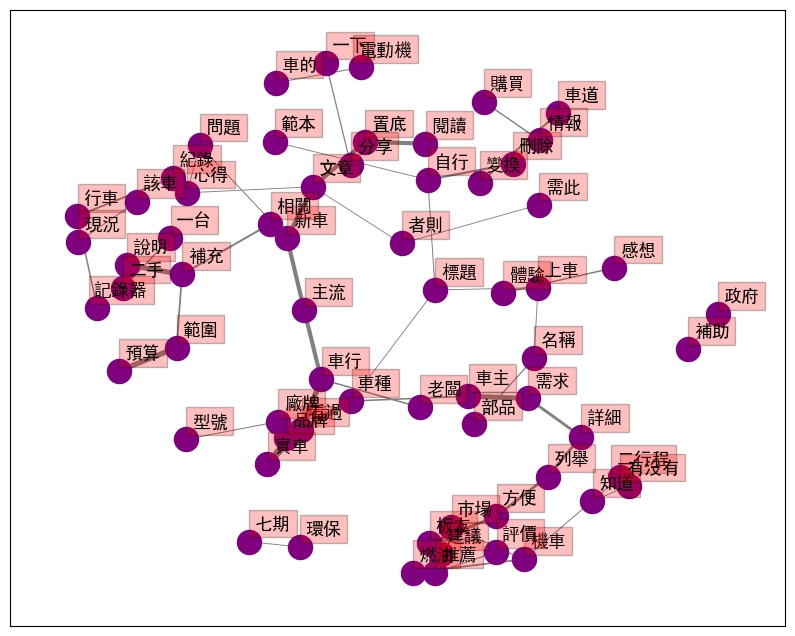

In [99]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## Pairwise corrslation

In [100]:
# 取常一起出現的bigram pair 前1500筆
b = {k:v for k,v in bigramfdist.most_common(1500)}
# b.items()

In [101]:
# 建立DataFrame
bigram_df = pd.DataFrame(list(b), columns=['word','word2']).assign(n=b.values())

In [102]:
# 每個bigram組合的次數
bigram_df.head()

,word,word2,n
0,看過,實車,408
1,車行,看過,399
2,預算,範圍,381
3,品牌,車種,372
4,補充,說明,365


In [107]:
# 詞彙在各文章中出現的次數
word_count2.head()

,artUrl,word,count
0,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,一直,1
1,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,不用,1
2,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,二手,1
3,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,停樓,1
4,https://www.ptt.cc/bbs/biker/M.1457017502.A.6A...,停車場,1


In [108]:
#計算phi值
def phi_cor(df):
    # total x
    nx = len(set(word_count2[word_count2["word"]==df["word"]]["artUrl"]))
    tnx = len(MetaData)-nx
    # total y
    ny = len(set(word_count2[word_count2["word"]==df["word2"]]["artUrl"]))
    tny = len(MetaData)-ny
    # 有x 有y
    x_ls = list(word_count2[word_count2["word"]==df["word"]]["artUrl"]) #單獨有x
    y_ls = list(word_count2[word_count2["word"]==df["word2"]]["artUrl"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    # 有x 沒有y
    nxo = nx-nxy
    # 沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(MetaData["artUrl"]))-uxy) #取差集:全-有x有y
    # 沒有x 有y
    noy = ny-nxy
    # print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi

In [109]:
bigram_df["cor"] = bigram_df.apply(phi_cor, axis=1)
bigram_df = bigram_df[bigram_df["word"]!=bigram_df["word2"]]

In [127]:
bigram_df.head(20)

,word,word2,n,cor
0,看過,實車,408,0.863191
1,車行,看過,399,0.539942
2,預算,範圍,381,0.730686
3,品牌,車種,372,0.767379
4,補充,說明,365,0.696066
5,車主,需求,360,0.566852
6,實車,品牌,318,0.781574
7,閱讀,置底,301,0.965945
8,置底,文章,301,0.823886
9,文章,新車,299,0.537928


##  和詞彙相關性最高的10個詞彙

In [136]:
ice_sum = bigram_df[(bigram_df["word"]=="新車")].sort_values(by=['cor'], ascending = False).head(10)
taste_sum = bigram_df[(bigram_df["word"]=="需求")].sort_values(by=['cor'], ascending = False).head(10)

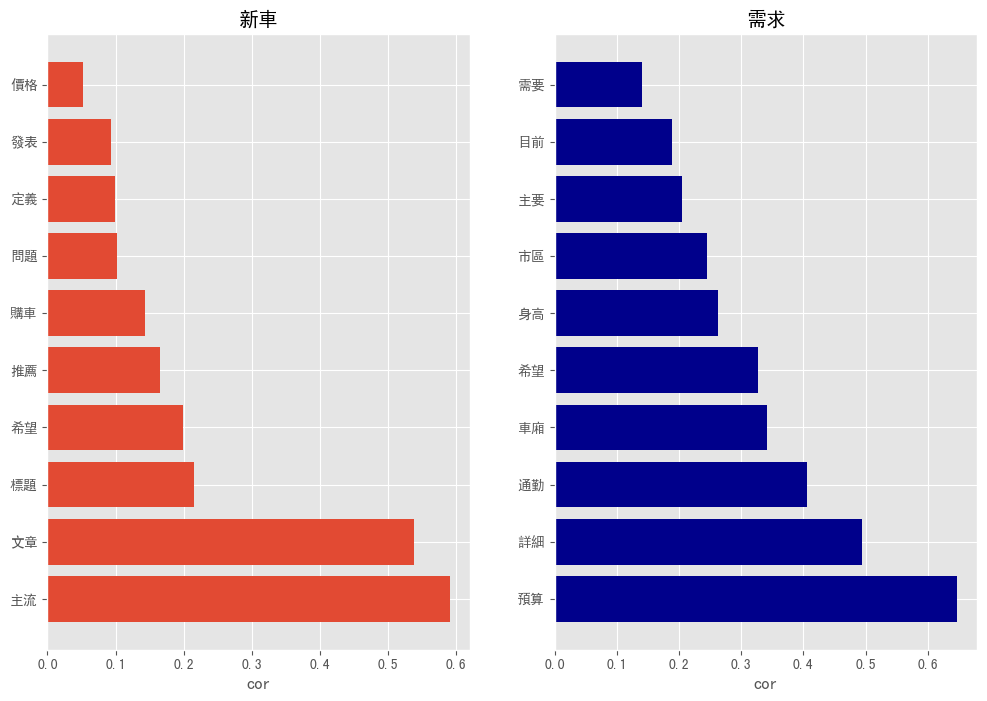

In [137]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('新車')
plt.xlabel('cor')
plt.barh(ice_sum['word2'],ice_sum['cor'])

plt.subplot(122)
plt.title('需求')
plt.xlabel('cor')
plt.barh(taste_sum['word2'],taste_sum['cor'],color="darkblue")


plt.show()